In [51]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [52]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.random import set_seed
import joblib

In [53]:
np.random.seed(13)
set_seed(12)
logins_per_user = 200
time_steps = 10

In [54]:
# Load the user login data
df = pd.read_csv('../../preprocessing/final_processed_user_data.csv')

In [55]:
print("class counts:\n", df["is_malicious"].value_counts())
print("\n%% of positive values in data: %.2f%%" % 
       ((df[df["is_malicious"] == 1].shape[0] / df.shape[0]) * 100))

class counts:
 0    63445
1     2555
Name: is_malicious, dtype: int64

% of positive values in data: 3.87%


In [56]:
id_encoder = LabelEncoder()
id_encoder.fit(df['user_id'].unique())

LabelEncoder()

In [57]:
country_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
country_encoder.fit(df['country'].unique().reshape(-1, 1))

browser_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
browser_encoder.fit(df['browser'].unique().reshape(-1, 1))

OS_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OS_encoder.fit(df['os_version'].unique().reshape(-1, 1))

device_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
device_encoder.fit(df['device'].unique().reshape(-1, 1))

time_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
time_encoder.fit(df['login_time'].unique().reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [58]:
transformed_uid = id_encoder.transform(df['user_id'].to_numpy().reshape(-1, 1))
encoded_uid= pd.DataFrame(transformed_uid, columns=['uid_code'])
df = pd.concat([df, encoded_uid], axis=1).drop(['user_id'], axis=1)

/Users/dinika/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [59]:
df.head()

,timestamp,login_time,country,browser,os_version,device,login_status,is_malicious,uid_code
0,1589912560607000000,evening,NO,Chrome,Chrome OS,desktop,1,0,148
1,1589986550384000000,afternoon,NO,Chrome,Chrome OS,desktop,1,0,148
2,1590056570709000000,late_morning,NO,Chrome,Chrome OS,desktop,1,0,148
3,1590086333604000000,evening,NO,Chrome,Chrome OS,desktop,1,0,148
4,1590170279391000000,evening,NO,Chrome,Chrome OS,desktop,1,0,148


In [60]:
min_max_scaler = MinMaxScaler()
uid_scaled = min_max_scaler.fit_transform(df['uid_code'].to_numpy().reshape(-1, 1))
uid_scaled = pd.DataFrame(uid_scaled, columns=['uid_scaled'])
df = pd.concat([df, uid_scaled], axis=1).drop(['uid_code'], axis=1)

In [61]:
df.head()

,timestamp,login_time,country,browser,os_version,device,login_status,is_malicious,uid_scaled
0,1589912560607000000,evening,NO,Chrome,Chrome OS,desktop,1,0,0.449848
1,1589986550384000000,afternoon,NO,Chrome,Chrome OS,desktop,1,0,0.449848
2,1590056570709000000,late_morning,NO,Chrome,Chrome OS,desktop,1,0,0.449848
3,1590086333604000000,evening,NO,Chrome,Chrome OS,desktop,1,0,0.449848
4,1590170279391000000,evening,NO,Chrome,Chrome OS,desktop,1,0,0.449848


In [62]:
transformed_country = country_encoder.transform(df['country'].to_numpy().reshape(-1, 1))
ohe_df_contry = pd.DataFrame(transformed_country, columns=country_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_contry], axis=1).drop(['country'], axis=1)

In [63]:
transformed_browser = browser_encoder.transform(df['browser'].to_numpy().reshape(-1, 1))
ohe_df_browser = pd.DataFrame(transformed_browser, columns=browser_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_browser], axis=1).drop(['browser'], axis=1)

In [64]:
transformed_os = OS_encoder.transform(df['os_version'].to_numpy().reshape(-1, 1))
ohe_df_os_version = pd.DataFrame(transformed_os, columns=OS_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_os_version], axis=1).drop(['os_version'], axis=1)

In [65]:
transformed_device = device_encoder.transform(df['device'].to_numpy().reshape(-1, 1))
ohe_df_device = pd.DataFrame(transformed_device, columns=device_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_device], axis=1).drop(['device'], axis=1)

In [66]:
transformed_time = time_encoder.transform(df['login_time'].to_numpy().reshape(-1, 1))
ohe_df_time = pd.DataFrame(transformed_time, columns=time_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df_time], axis=1).drop(['login_time'], axis=1)

In [67]:
joblib.dump(id_encoder,"encoders/id_encoder.joblib")
joblib.dump(country_encoder,"encoders/country_encoder.joblib")
joblib.dump(browser_encoder,"encoders/browser_encoder.joblib")
joblib.dump(OS_encoder,"encoders/OS_encoder.joblib")
joblib.dump(device_encoder,"encoders/device_encoder.joblib")
joblib.dump(time_encoder,"encoders/time_encoder.joblib")
joblib.dump(min_max_scaler,"encoders/uid_min_max_scaler.joblib")

['encoders/uid_min_max_scaler.joblib']

In [68]:
df.head()

,timestamp,login_status,is_malicious,uid_scaled,x0_AU,x0_BE,x0_BR,x0_CA,x0_CH,x0_CZ,...,x0_unknown,x0_afternoon,x0_early_morning,x0_evening,x0_late_evening,x0_late_morning,x0_late_night,x0_morning,x0_night,x0_noon
0,1589912560607000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1589986550384000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1590056570709000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1590086333604000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1590170279391000000,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
predictors = df.drop(['is_malicious'], axis = 1)
predictors = df.drop(['timestamp'], axis = 1)
target = df["is_malicious"]

In [70]:
target.describe()

count    66000.000000
mean         0.038712
std          0.192909
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_malicious, dtype: float64

In [71]:
predictors.head(10)

,login_status,is_malicious,uid_scaled,x0_AU,x0_BE,x0_BR,x0_CA,x0_CH,x0_CZ,x0_DE,...,x0_unknown,x0_afternoon,x0_early_morning,x0_evening,x0_late_evening,x0_late_morning,x0_late_night,x0_morning,x0_night,x0_noon
0,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,0,0.449848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
def split_data(sequences, train_fraction, validation_fraction, test_fraaction):
    train_size = int(len(sequences) * train_fraction)
    validation_size = int(len(sequences) * validation_fraction)
    test_size = int(len(sequences) * test_fraaction)
    train, validation, test = sequences[:train_size], sequences[train_size:train_size+validation_size], sequences[train_size+validation_size:]
    return train, validation, test

In [73]:
#get unique value counts in target
target.value_counts()

0    63445
1     2555
Name: is_malicious, dtype: int64

In [99]:
columns = df.columns
write_colunms = True
user_data_file = "../../data/LSTM_user_data/user_past_data.csv"

train_x = []
train_y = []
test_x = []
test_y = []
val_x = []
val_y = []

unique_users = df['uid_scaled'].unique().tolist()

for user in unique_users:
    user_df = df[df['uid_scaled'] == user]
    to_csv = user_df.tail(time_steps)
    to_csv.to_csv(user_data_file, mode='a', header=write_colunms, columns=columns)
    write_colunms = False
    predictors_local = user_df.drop(["is_malicious"], axis = 1)
    predictors_local = user_df.drop(["timestamp"], axis = 1)
    target_local = user_df["is_malicious"]
    user_sequences = []
    user_y_values = []
    for i in range(time_steps, len(user_df)+1):
        seq = predictors_local.iloc[i - time_steps:i].values
        user_sequences.append(seq)
        out_seq = target_local.iloc[i-1]
        user_y_values.append(out_seq)
    user_train_X, user_val_X, user_test_X = split_data(user_sequences,0.6,0.2,0.2) 
    user_train_y, user_val_y, user_test_y = split_data(user_y_values,0.6,0.2,0.2)
    train_x.extend(user_train_X)
    train_y.extend(user_train_y)
    val_x.extend(user_val_X)
    val_y.extend(user_val_y)
    test_x.extend(user_test_X)
    test_y.extend(user_test_y)
    


In [75]:
len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y)

(37620, 37620, 12540, 12540, 12870, 12870)

In [76]:
# print unique value counts in train_y
unique, counts = np.unique(train_y, return_counts=True)
print(unique, counts )


[0 1] [36196  1424]


In [77]:
# print unique value counts in val_y
unique, counts = np.unique(val_y, return_counts=True)
print(unique, counts )

[0 1] [12002   538]


In [78]:
# print unique value counts in test_y
unique, counts = np.unique(test_y, return_counts=True)
print(unique, counts )

[0 1] [12365   505]


In [79]:
X_train = np.array(train_x)
y_train = np.array(train_y)
y_train = y_train.reshape(y_train.shape[0], 1)
X_val = np.array(val_x)
y_val = np.array(val_y)
y_val = y_val.reshape(y_val.shape[0], 1)
X_test = np.array(test_x)
y_test = np.array(test_y)
y_test = y_test.reshape(y_test.shape[0], 1)

# sequences_np = np.array(sequences)
# y_sequesnces_np = np.array(y_values)
# y_sequesnces_np = y_sequesnces_np.reshape(y_sequesnces_np.shape[0], 1)

In [80]:
print("X_train shape:\n", X_train.shape)
print("y_train shape:\n", y_train.shape)
print("X_val shape:\n", X_val.shape)
print("y_val shape:\n", y_val.shape)
print("X_test shape:\n", X_test.shape)
print("y_test shape:\n", y_test.shape)

X_train shape:
 (37620, 10, 82)
y_train shape:
 (37620, 1)
X_val shape:
 (12540, 10, 82)
y_val shape:
 (12540, 1)
X_test shape:
 (12870, 10, 82)
y_test shape:
 (12870, 1)


In [81]:
X_train.shape[2]

82

In [82]:
# define the LSTM model
model = keras.Sequential([
    layers.LSTM(64, input_shape=(time_steps, X_train.shape[2]), return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(16, return_sequences=False),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [83]:
# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            37632     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 53,201
Trainable params: 53,201
Non-trainable params: 0
_________________________________________________________________


In [84]:
batch_size = logins_per_user - time_steps + 1
batch_size

191

In [85]:
# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2, shuffle=False)

Epoch 1/10
197/197 - 7s - loss: 0.1867 - accuracy: 0.9564 - val_loss: 0.1145 - val_accuracy: 0.9663 - 7s/epoch - 35ms/step
Epoch 2/10
197/197 - 4s - loss: 0.0924 - accuracy: 0.9679 - val_loss: 0.0784 - val_accuracy: 0.9767 - 4s/epoch - 18ms/step
Epoch 3/10
197/197 - 4s - loss: 0.0668 - accuracy: 0.9766 - val_loss: 0.0696 - val_accuracy: 0.9753 - 4s/epoch - 18ms/step
Epoch 4/10
197/197 - 4s - loss: 0.0597 - accuracy: 0.9797 - val_loss: 0.0670 - val_accuracy: 0.9742 - 4s/epoch - 18ms/step
Epoch 5/10
197/197 - 4s - loss: 0.0566 - accuracy: 0.9802 - val_loss: 0.0639 - val_accuracy: 0.9746 - 4s/epoch - 18ms/step
Epoch 6/10
197/197 - 4s - loss: 0.0541 - accuracy: 0.9808 - val_loss: 0.0612 - val_accuracy: 0.9759 - 4s/epoch - 18ms/step
Epoch 7/10
197/197 - 4s - loss: 0.0501 - accuracy: 0.9815 - val_loss: 0.0565 - val_accuracy: 0.9776 - 4s/epoch - 18ms/step
Epoch 8/10
197/197 - 4s - loss: 0.0442 - accuracy: 0.9834 - val_loss: 0.0442 - val_accuracy: 0.9840 - 4s/epoch - 18ms/step
Epoch 9/10
197/1

In [86]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

403/403 [==============================] - 1s 2ms/step


In [87]:
print("train_pred shape:\n", train_pred.shape)
print("val_pred shape:\n", val_pred.shape)
print("test_pred shape:\n", test_pred.shape)

train_pred shape:
 (37620, 1)
val_pred shape:
 (12540, 1)
test_pred shape:
 (12870, 1)


In [88]:
test_pred

array([[0.00063961],
       [0.00063793],
       [0.00063444],
       ...,
       [0.0007107 ],
       [0.00071029],
       [0.00070505]], dtype=float32)

In [89]:
# test_error = pd.DataFrame({"prediction": test_pred,
#                         "actual": y_test})

test_pred_df = pd.DataFrame(test_pred)

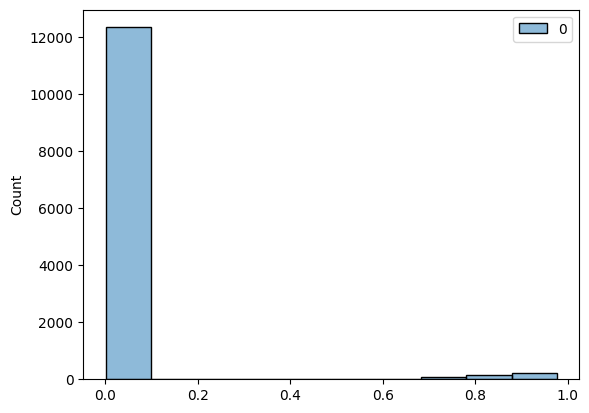

In [90]:
g = sns.histplot(data = test_pred_df, bins = 10)
# plt.axvline(lstm.threshold, color = "r", label = "threshold")
# plt.legend(loc = "upper right")
# g.set_yscale("log")
plt.show()

In [91]:
def mapPredictionsToClass(pred):
    pred_class = []
    for i in pred:
        if i > 0.5:
            pred_class.append(1)
        else:
            pred_class.append(0)
    return pred_class

In [92]:
train_pred = mapPredictionsToClass(train_pred)
val_pred = mapPredictionsToClass(val_pred)
test_pred = mapPredictionsToClass(test_pred)

In [93]:
conf_matrix = confusion_matrix(y_test, test_pred)
print("Accuracy train: %.2f%%" % (100 * accuracy_score(y_train, train_pred)))
print("Accuracy validation: %.2f%%" % (100 * accuracy_score(y_val, val_pred)))
print("Accuracy test: %.2f%%" % (100 * accuracy_score(y_test, test_pred)))
print("Precision: %.2f%%" % (100 * precision_score(y_test, test_pred)))
print("Recall: %.2f%%" % (100 * recall_score(y_test, test_pred)))

Accuracy train: 99.99%
Accuracy validation: 100.00%
Accuracy test: 99.98%
Precision: 100.00%
Recall: 99.41%


In [94]:
conf_matrix = confusion_matrix(y_test, test_pred)

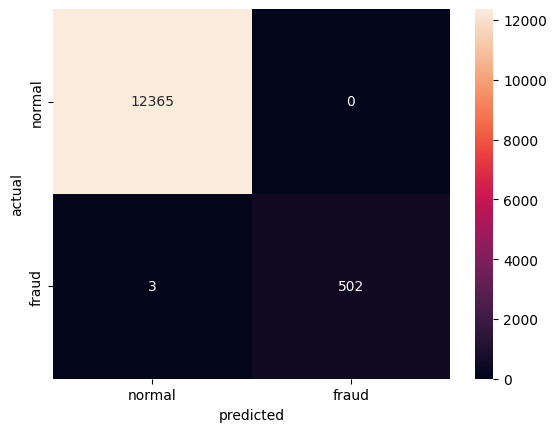

In [95]:
sns.heatmap(conf_matrix, 
            xticklabels = ["normal", "fraud"], 
            yticklabels=["normal", "fraud"], 
            annot = True, fmt = "d")
plt.ylabel("actual")
plt.xlabel("predicted")
plt.show()

In [96]:
#Store model
model.save('model/supervised_lstm.h5')